In [1]:
# coding: utf-8

"""
title: COVID-19 Recover-Deaths Analysis in the World
date: 2020/04/15
author: okimebarun
url: https://github.com/okimebarun/01_COVID19_analysis
url: https://qiita.com/oki_mebarun
"""

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import locale

In [2]:
font = {'family' : 'IPAexGothic'}
plt.rc('font', **font)

In [3]:
##########################################################################################

In [4]:
def getSumOfCountry01(df, country):
    df1 = df[df["Country/Region"] == country]
    # summarise for each country/region
    if df1['Province/State'].isnull().any():
        df2 = df1.fillna({'Province/State':'SUM'})
        df3 = df2[df2['Province/State'] == 'SUM']
    else:
        df3 = pd.DataFrame(df1.sum(axis=0)).T
        df3['Province/State'] = 'SUM'
        df3['Country/Region'] = df1.iloc[0,1]    
    return df3

def getSumOfCountry02(df, country):
    df1 = getSumOfCountry01(df, country)
    # drop unnecessary information
    df2 = df1.iloc[:,4:].T
    df2.columns = ['PS']
    # convert date type
    ldat = [pd.Timestamp(e) for e in df2.index.values]
    pdat = df2['PS'].values.astype(np.int64)
    df3 = pd.DataFrame({'date':ldat, 'PS':pdat})
    # sort by date
    df3 = df3.sort_values('date').reset_index(drop = True)    
    #
    return df3

def getDiffOfCountry01(df, country):
    df1 = getSumOfCountry02(df, country)
    df2 = df1.copy()
    # make difference at each day
    for i in range(1,len(df1)):
        df2.at[i, 'P'] = df1.at[i, 'PS'] - df1.at[i-1, 'PS'] 
    return df2

In [5]:
def readCsvOfWorldArea_Confirmed(area : None):
    # 下記URLよりダウンロード
    # https://github.com/CSSEGISandData/COVID-19
    fcsv = u'time_series_covid19_confirmed_global.csv'
    df = pd.read_csv(fcsv, header=0, encoding='utf8')
    df1 = getDiffOfCountry01(df, area)
    return df1

In [6]:
def readCsvOfWorldArea_Recovered(area : None):
    # 下記URLよりダウンロード
    # https://github.com/CSSEGISandData/COVID-19
    fcsv = u'time_series_covid19_recovered_global.csv'
    df = pd.read_csv(fcsv, header=0, encoding='utf8')
    df1 = getDiffOfCountry01(df, area)
    df2 = df1.rename(columns={'P':'R', 'PS':'RS'})
    return df2

In [7]:
def readCsvOfWorldArea_Deaths(area : None):
    # 下記URLよりダウンロード
    # https://github.com/CSSEGISandData/COVID-19
    fcsv = u'time_series_covid19_deaths_global.csv'
    df = pd.read_csv(fcsv, header=0, encoding='utf8')
    df1 = getDiffOfCountry01(df, area)
    df2 = df1.rename(columns={'P':'D', 'PS':'DS'})
    return df2

In [8]:
##########################################################################################

In [9]:
def getWorldAreaList02():
    fcsv = u'time_series_covid19_confirmed_global.csv'
    df = pd.read_csv(fcsv, header=0, encoding='utf8')
    arealist = df["Country/Region"]
    arealist = arealist[~arealist.duplicated()]
    return arealist

def getFilteredAreaList(th):
    fcsv = u'time_series_covid19_confirmed_global.csv'
    df = pd.read_csv(fcsv, header=0, encoding='utf8')
    #
    arealist = getWorldAreaList02()
    #
    l1 = []
    #
    for area in arealist:
        df1 = getSumOfCountry02(df, area)
        if df1.iloc[-1]['PS'] >= th: # 累積感染者でフィルタ
            l1.append(area)
    #
    return l1

arealist = getWorldAreaList02()

In [10]:
##########################################################################################

In [11]:
def makeCalcFrame(days):
    t_1 = pd.Timestamp(2020,1,24) # 計算開始日
    td = pd.Timedelta('1 days')
    #
    npd = [[t_1 + td * i, 0, 0, 0 ] for i in range(0,days)]
    df1 = pd.DataFrame(npd)
    df1.columns = ['date', 'C','rR', 'rD']
    #
    return df1

In [12]:
def mergeCalcFrame(df1, df2):
    return pd.merge(df1, df2, on='date', how='left').fillna(0)

In [13]:
##########################################################################################

In [14]:
def calcCRD(df, keys):
    #
    nth = keys['nth']
    tf = keys['tf']
    #
    nrow  = len(df)
    getV  = lambda s, tag: df.loc[s, tag] if s < nrow else np.NaN
    # tf [days]先まで移動平均
    getV2 = lambda s, tag: np.nanmean([getV(u, tag) for u in range(s,s + tf)])
    df.loc[0, 'C'] = 0.
    for t in range(1, nrow):
        df.loc[t, 'C'] = getV(t, 'PS') - getV(t, 'RS') - getV(t, 'DS')
        if df.loc[t-1, 'C'] > nth: # 分母が小さいことへの対策用
            df.loc[t, 'rR'] = getV2(t, 'R') / df.loc[t-1, 'C']
            df.loc[t, 'rD'] = getV2(t, 'D') / df.loc[t-1, 'C']
        else:
            df.loc[t, 'rR'] = np.NaN
            df.loc[t, 'rD'] = np.NaN
    return df

In [15]:
##########################################################################################

In [16]:
def CRDinWorldArea01(area):
    keys = { 'nth':100, 'tf': 3 }
    df1 = makeCalcFrame(100) #
    df2 = readCsvOfWorldArea_Confirmed(area)
    df3 = readCsvOfWorldArea_Recovered(area)
    df4 = readCsvOfWorldArea_Deaths(   area)
    df = df1
    df = mergeCalcFrame(df, df2)
    df = mergeCalcFrame(df, df3)
    df = mergeCalcFrame(df, df4)
    df = calcCRD(df, keys)
    return df

In [17]:
##########################################################################################

In [18]:
def calcAveCR(df):
    return np.nanmean(df['rR']), np.nanmean(df['rD'])
    
def showAveCRD_01( dflist ):
    # show R0
    fig, ax1 = plt.subplots( figsize=(5,5), dpi=200, facecolor='skyblue')
    for df, area in dflist:
        rr, rd = calcAveCR(df)
        ax1.plot(rr, rd, 'o')
        ax1.text(1.02*rr,1.02*rd, area)

    ax1.legend()
    ax1.set_xlim(0,  )
    ax1.set_ylim(0,  )
    ax1.set_xlabel('Recoverd/in-Treatment ratio')
    ax1.set_ylabel('Deaths/in-Treatment ratio')
    ax1.grid(True)
    ax1.set_title('COVID-19 Treatment Performance (temporary)')
    #
    return fig

C:\Users\rse52\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


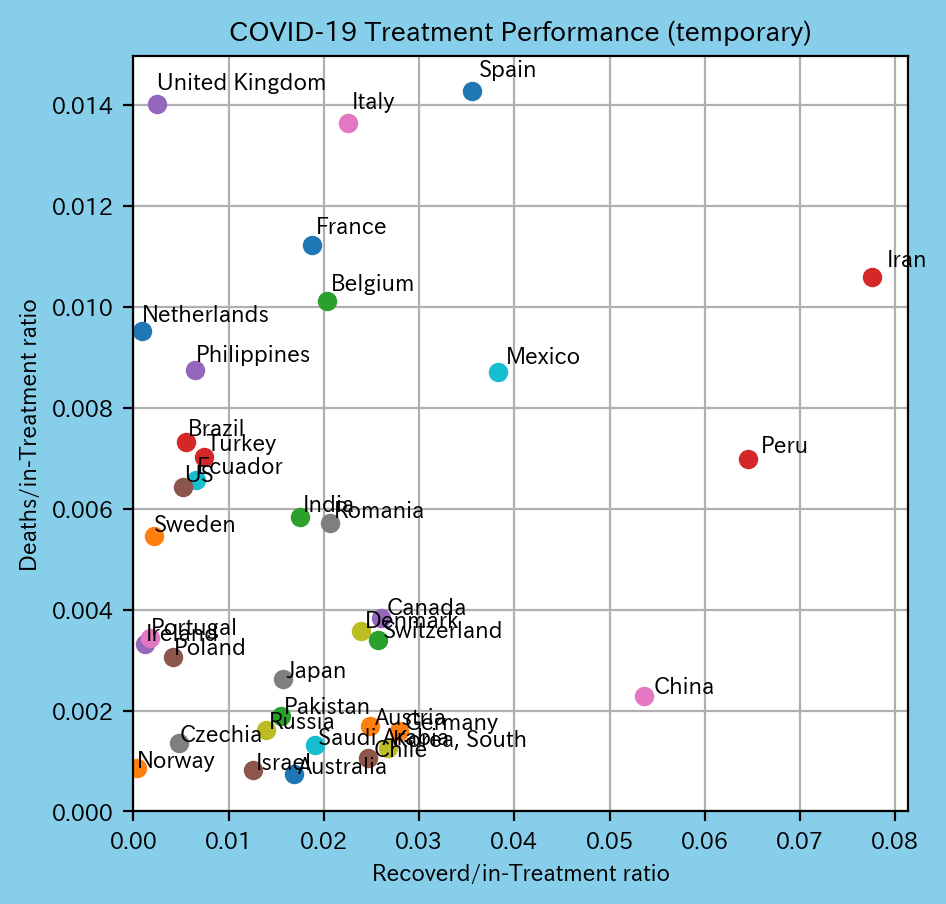

In [19]:
# filtered
th = 5000
title = "COVID-19 World"
arealist = getFilteredAreaList( th )
dflist_APF = [ [CRDinWorldArea01(area), area] for area in arealist]

plt.rcParams["font.size"] = 8
showAveCRD_01(dflist_APF)
plt.show()

In [20]:
##########################################################################################

In [21]:
def showResultCRD_02( ylabel, ax, df, area):
    df1 = df.rename(columns={'C':'in Treatment',ylabel:area})
    df1.plot(x='in Treatment',y=area, style='p', ax=ax)
    ax.set_ylim(0,  )
    ax.set_xscale("symlog", linthreshy=1)
    ax.grid(True)

In [22]:
def showCRDforAreaList_02( title, ylabel, arealist_l, arealist_r):
    ftitle = "COVID-19 {}".format(title)

    fig = plt.figure(figsize=(9,5), dpi=200, facecolor='skyblue')
    ax1 = fig.add_axes([0.1, 0.1, 0.35, 0.9])
    ax2 = fig.add_axes([0.5, 0.1, 0.35, 0.9])

    fig.text(0.3,1.07,ftitle,fontsize=12)
    plt.rcParams["font.size"] = 8

    dflist_l = [ [CRDinWorldArea01(area), area] for area in arealist_l]
    dflist_r = [ [CRDinWorldArea01(area), area] for area in arealist_r]
    ymax = 0
    for df, area in dflist_l:
        showResultCRD_02( ylabel, ax1, df, area)
        ymax = max(ymax, max(df[ylabel]))
    for df, area in dflist_r:
        showResultCRD_02( ylabel, ax2, df, area)
        ymax = max(ymax, max(df[ylabel]))

    ax1.set_ylim(0, ymax*1.2)
    ax2.set_ylim(0, ymax*1.2)
    ax1.set_xlim(50, pow(10,6))
    ax2.set_xlim(50, pow(10,6))

    ax1.set_title(title,fontsize=12)
    ax1.legend(bbox_to_anchor=(0, 1), loc='upper left', borderaxespad=1, fontsize=8)
    ax2.set_title(title,fontsize=12)
    ax2.legend(bbox_to_anchor=(0, 1), loc='upper left', borderaxespad=1, fontsize=8)
    plt.show()
    return fig

C:\Users\rse52\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  'left=%s, right=%s') % (left, right))


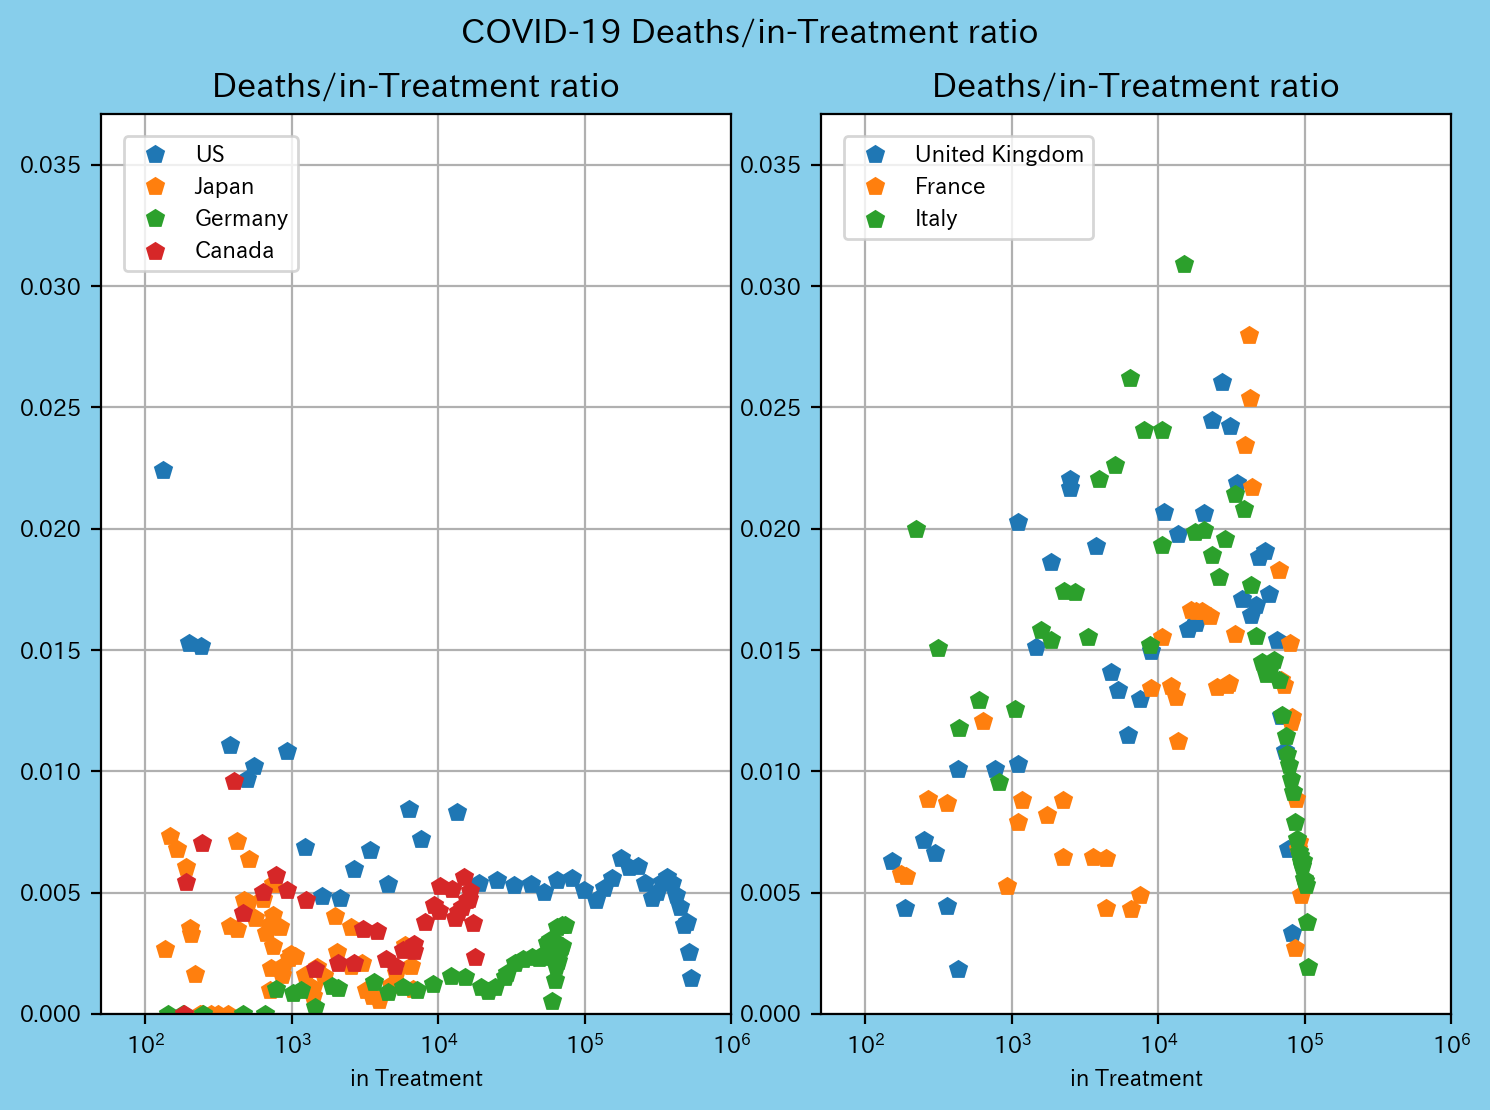

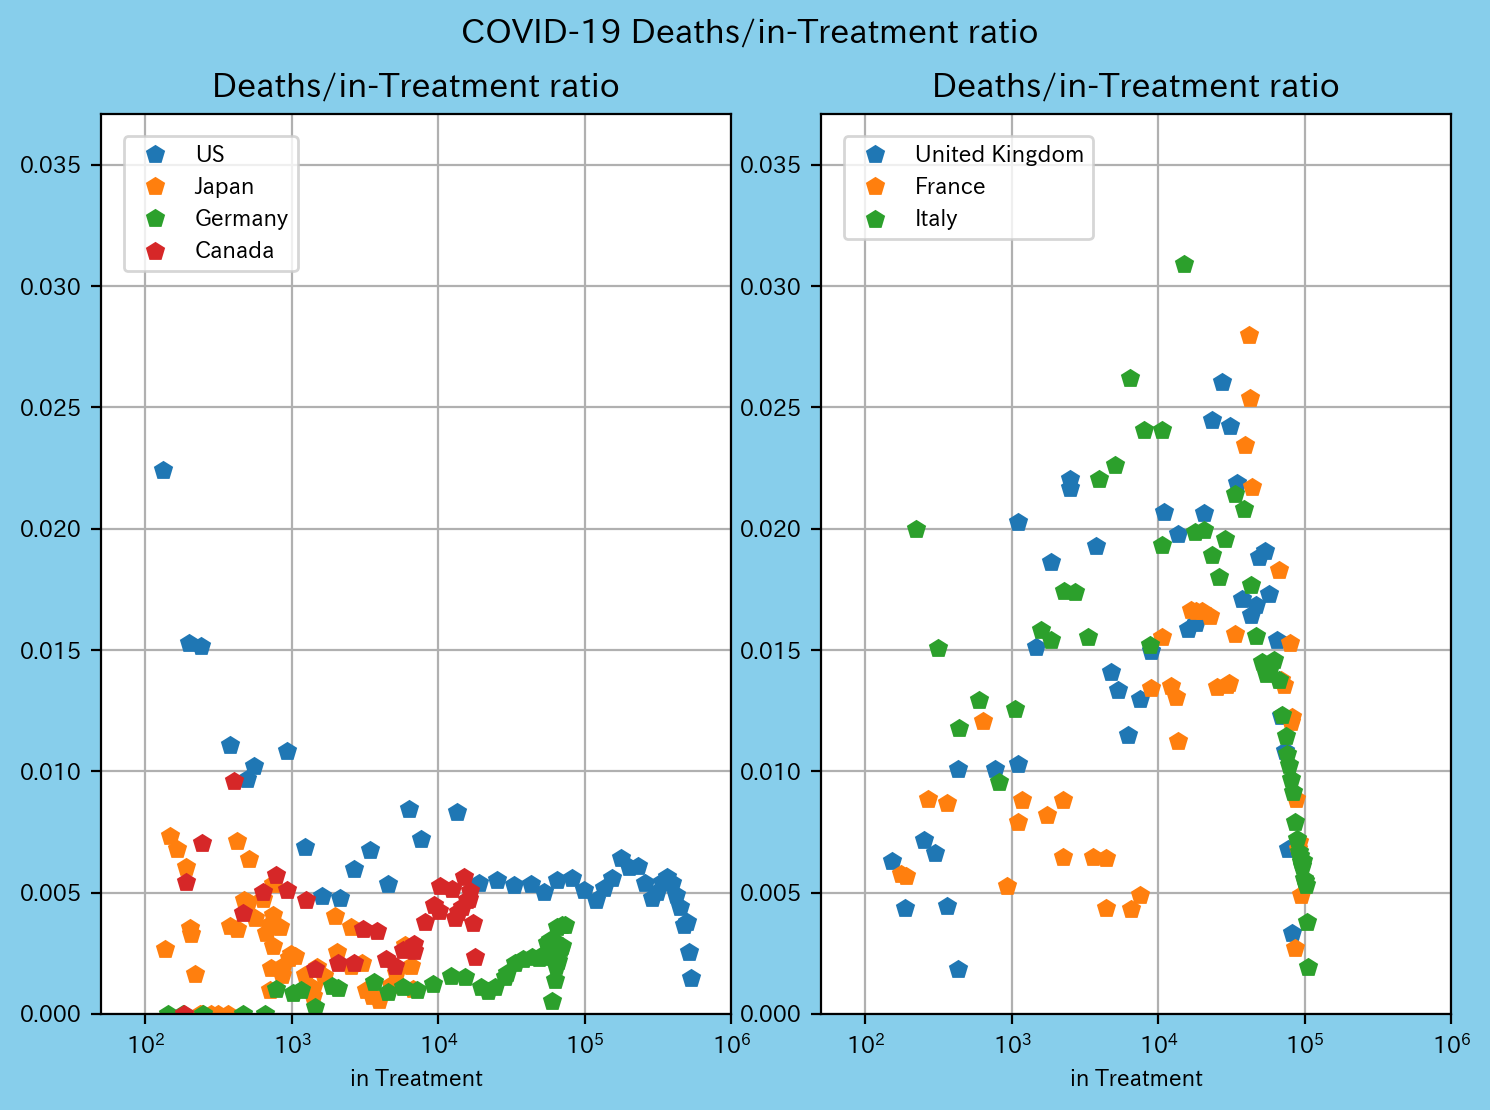

In [23]:
# G7
arealist_l = ['US', 'Japan', 'Germany', 'Canada']
arealist_r = [ 'United Kingdom', 'France', 'Italy']

title = 'Deaths/in-Treatment ratio'
ylabel = 'rD'
showCRDforAreaList_02(title, ylabel, arealist_l, arealist_r)

C:\Users\rse52\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  'left=%s, right=%s') % (left, right))


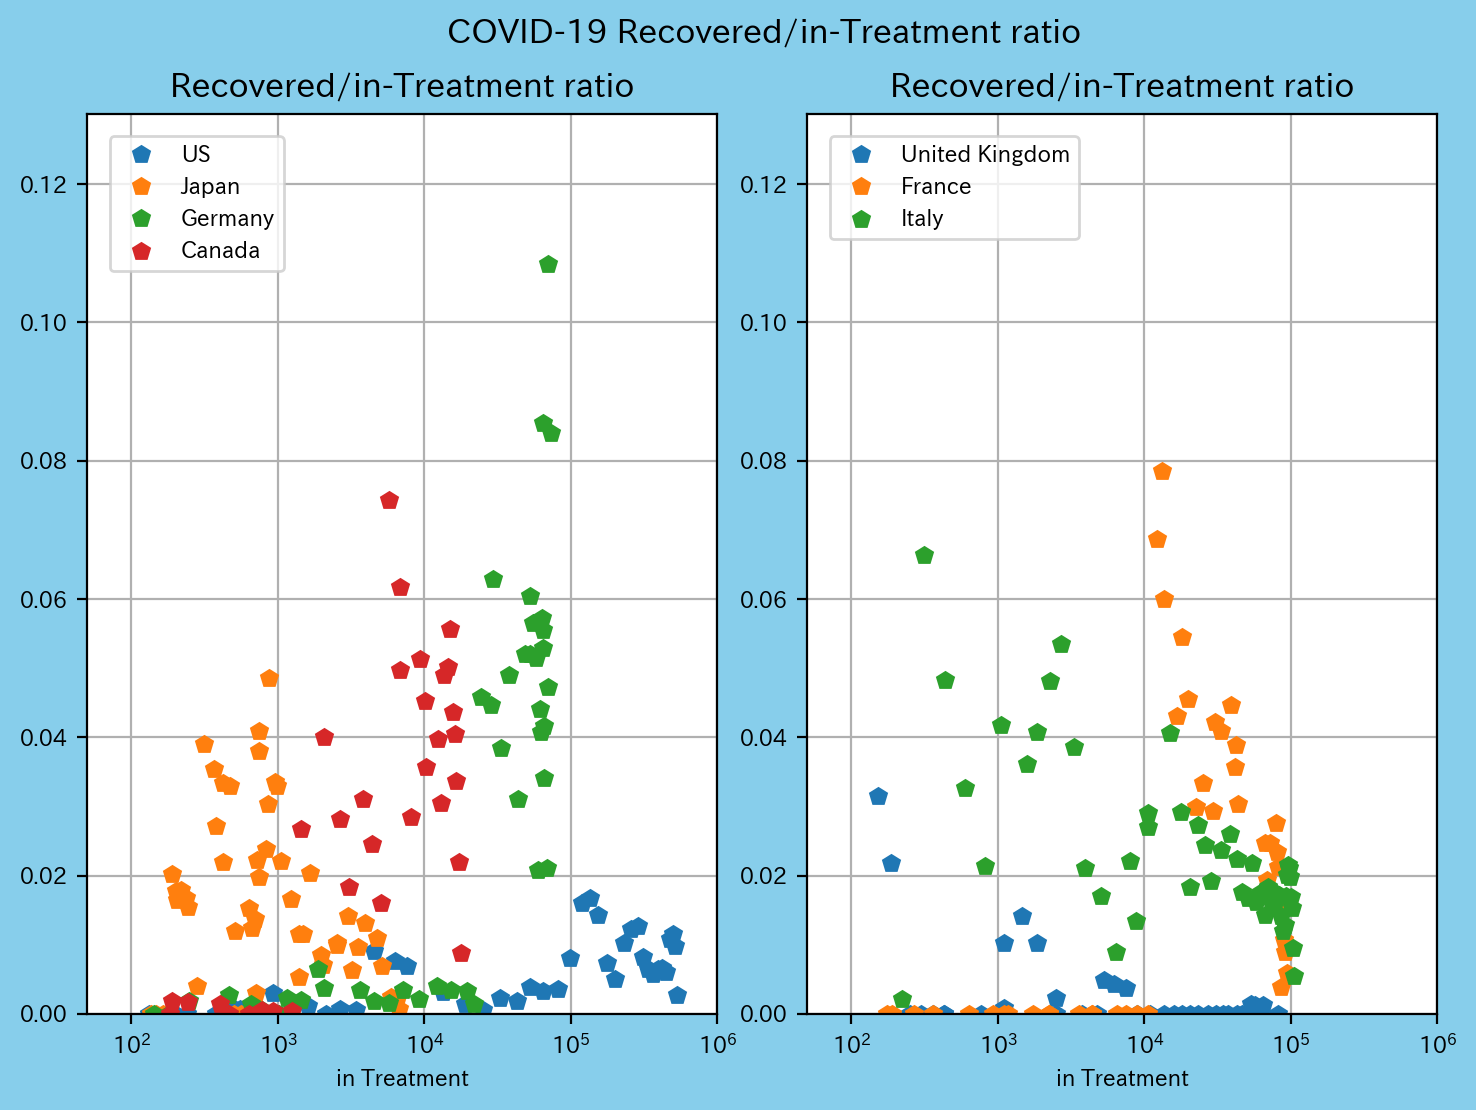

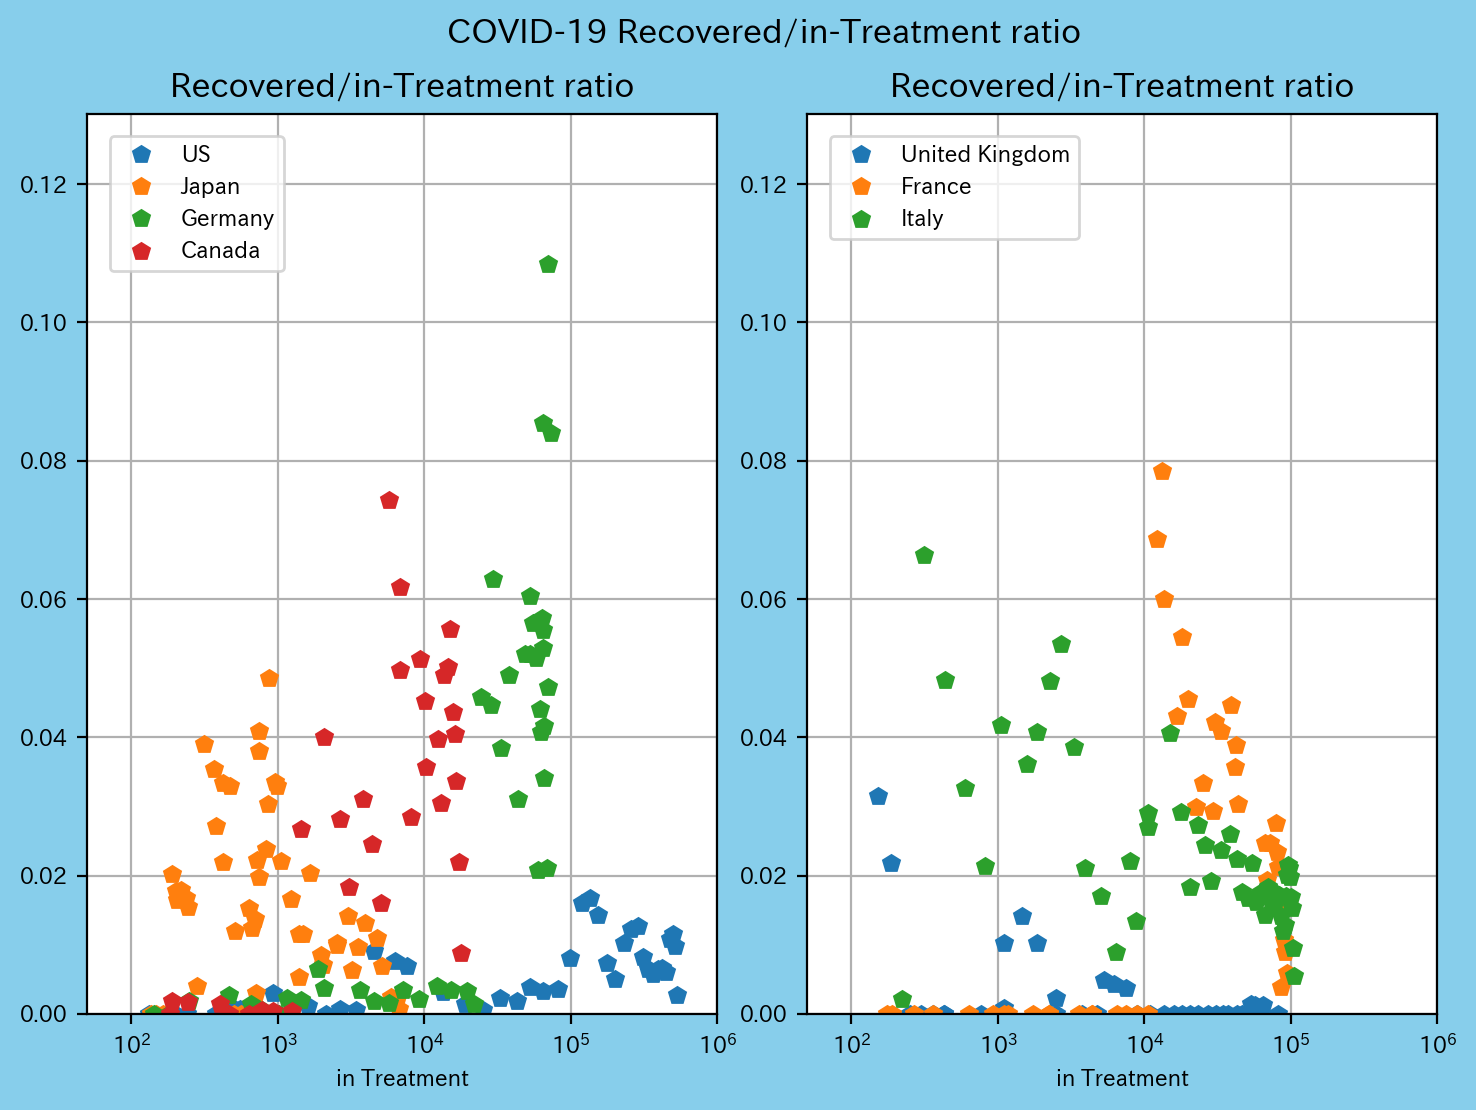

In [24]:
title = 'Recovered/in-Treatment ratio'
ylabel = 'rR'
showCRDforAreaList_02(title, ylabel, arealist_l, arealist_r)

C:\Users\rse52\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  'left=%s, right=%s') % (left, right))


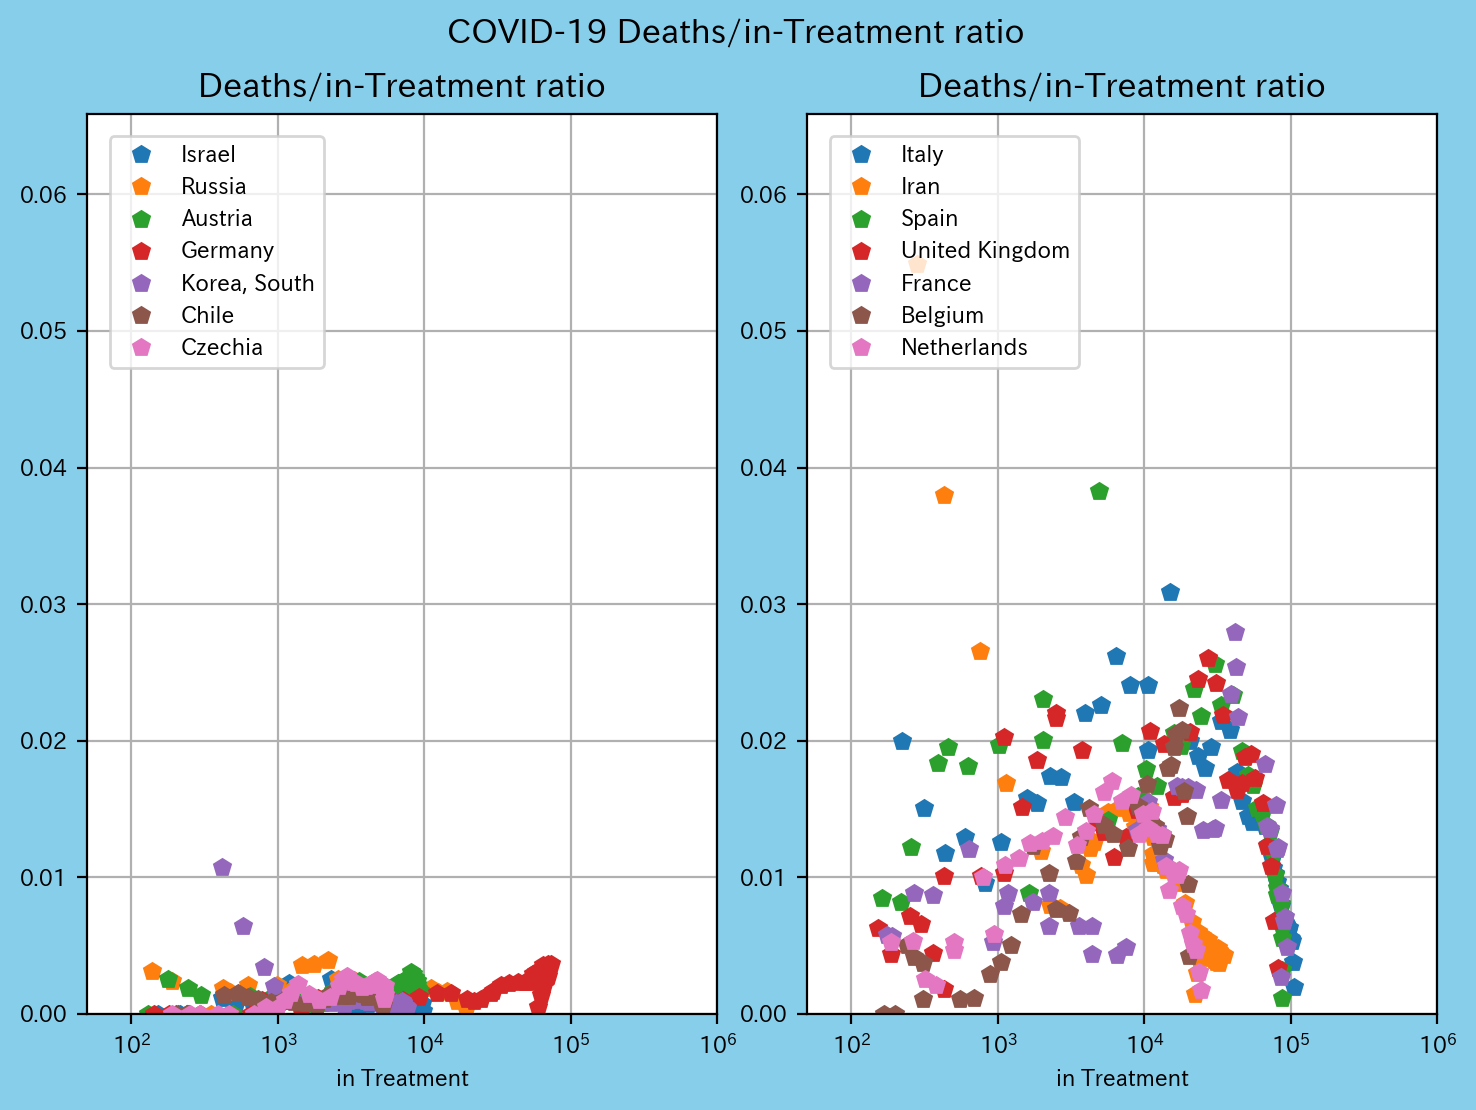

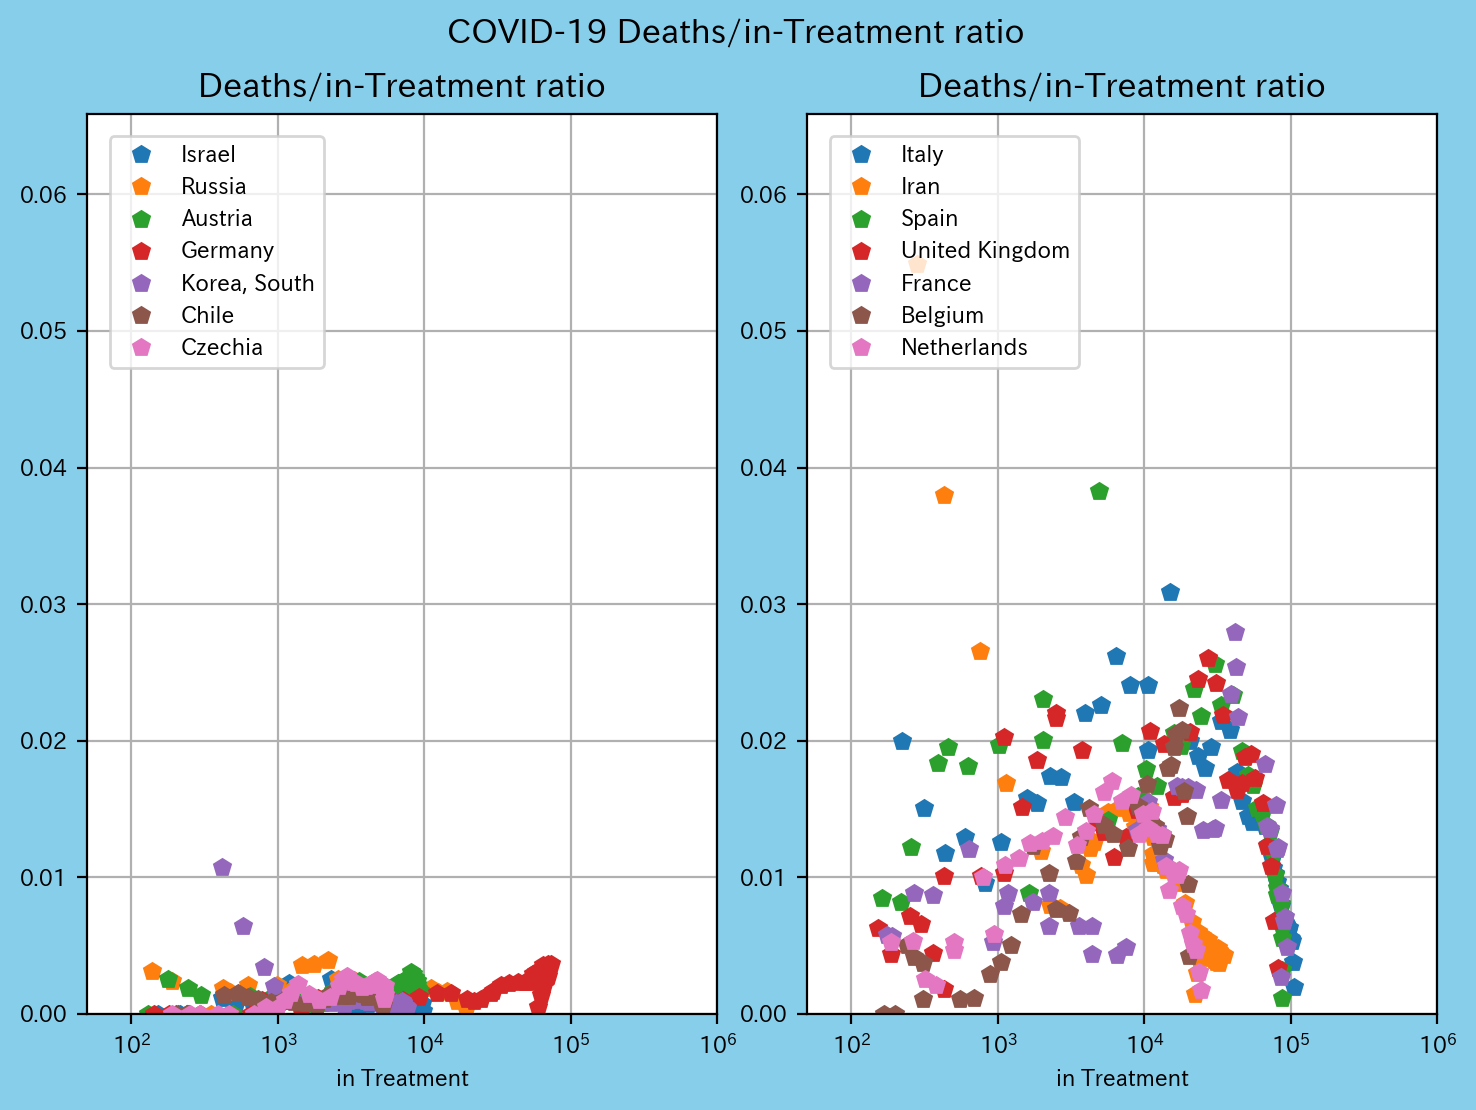

In [25]:
# good/bad
arealist_l = [ 'Israel', 'Russia', 'Austria', 'Germany', 'Korea, South', 'Chile', 'Czechia'  ]
arealist_r = [ 'Italy', 'Iran',  'Spain', 'United Kingdom', 'France', 'Belgium', 'Netherlands' ]

title = 'Deaths/in-Treatment ratio'
ylabel = 'rD'
showCRDforAreaList_02(title, ylabel, arealist_l, arealist_r)

C:\Users\rse52\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  'left=%s, right=%s') % (left, right))


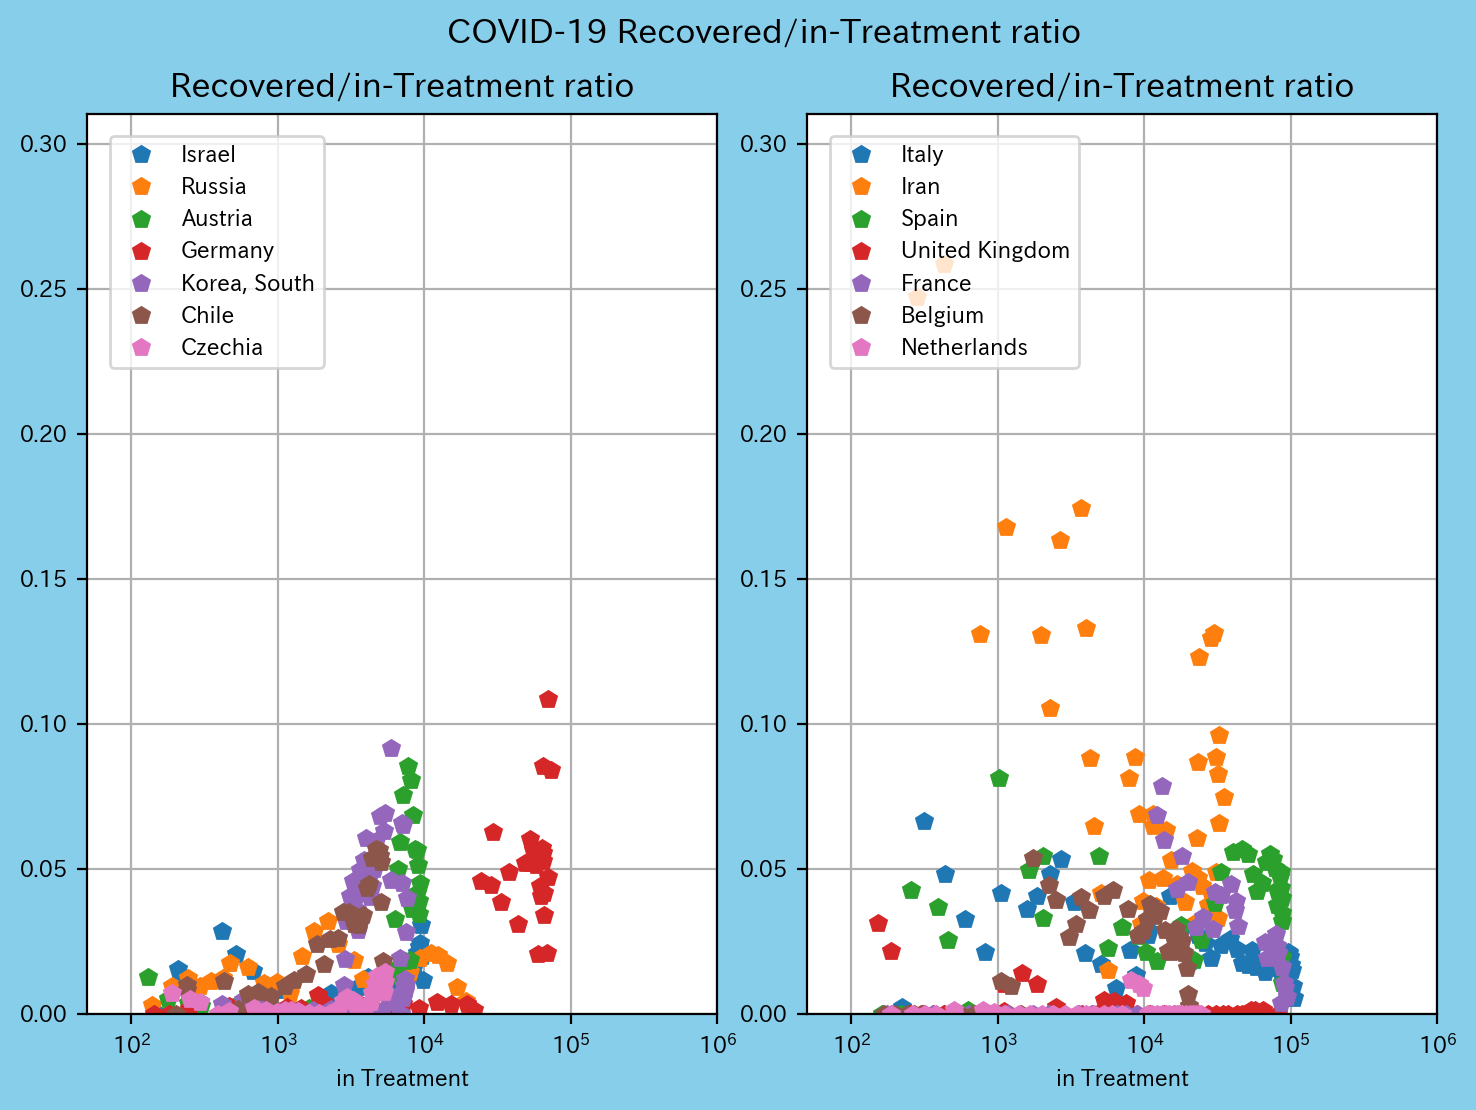

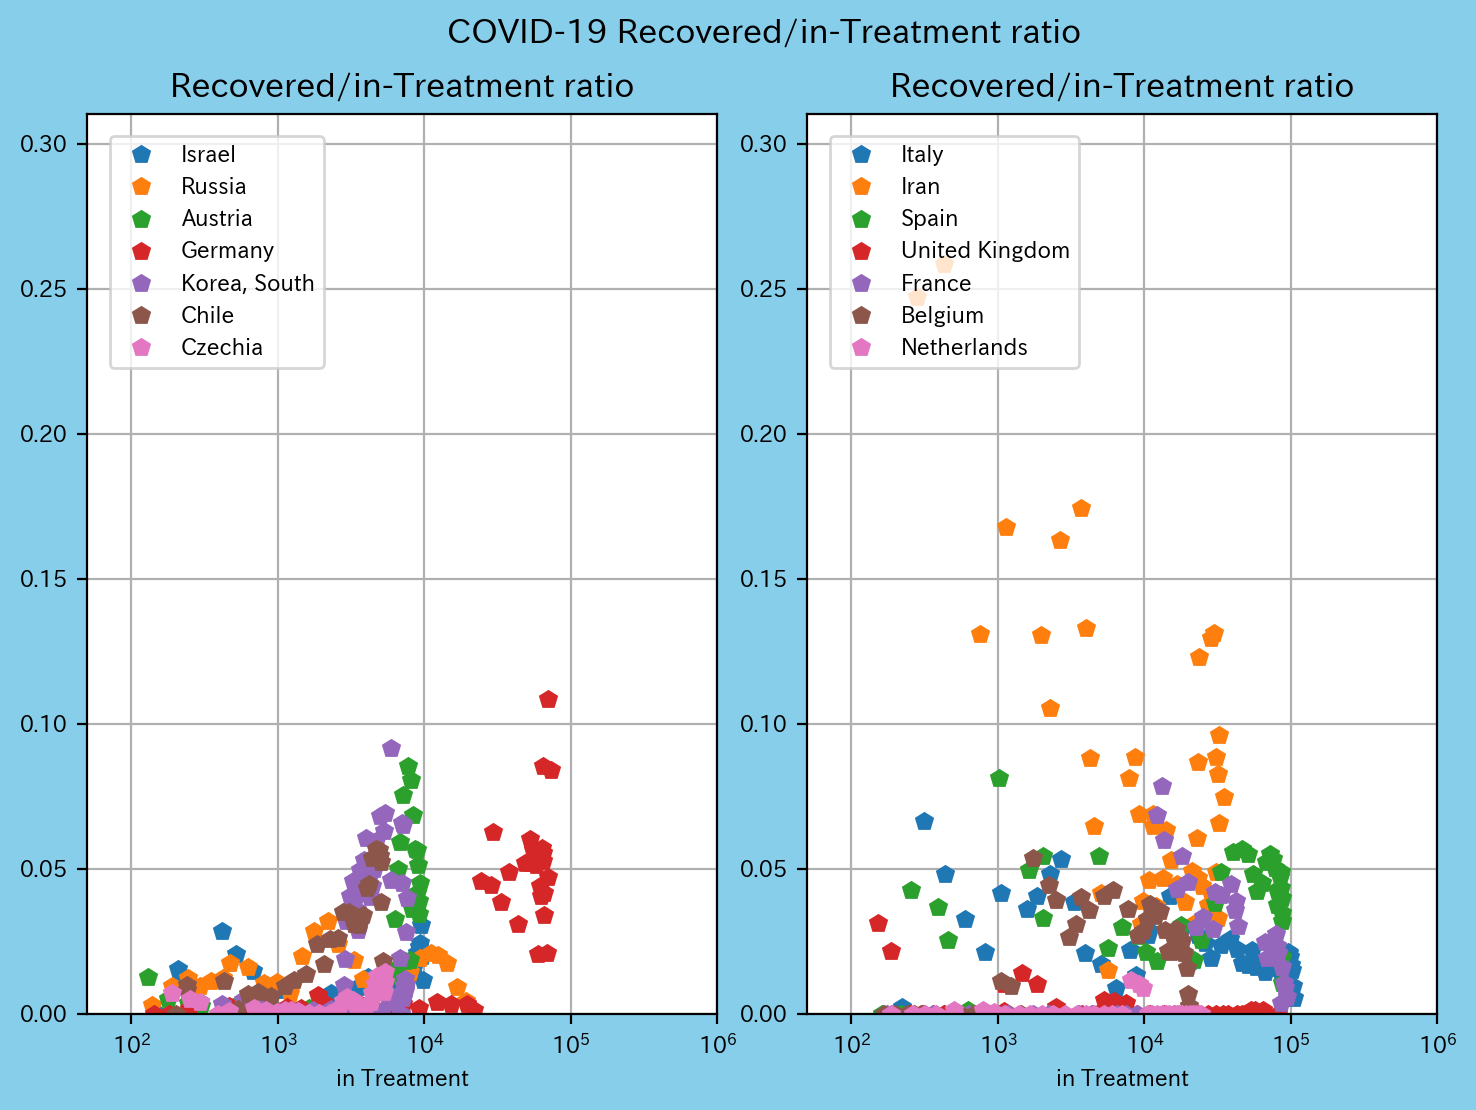

In [26]:
title = 'Recovered/in-Treatment ratio'
ylabel = 'rR'
showCRDforAreaList_02(title, ylabel, arealist_l, arealist_r)

C:\Users\rse52\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  'left=%s, right=%s') % (left, right))


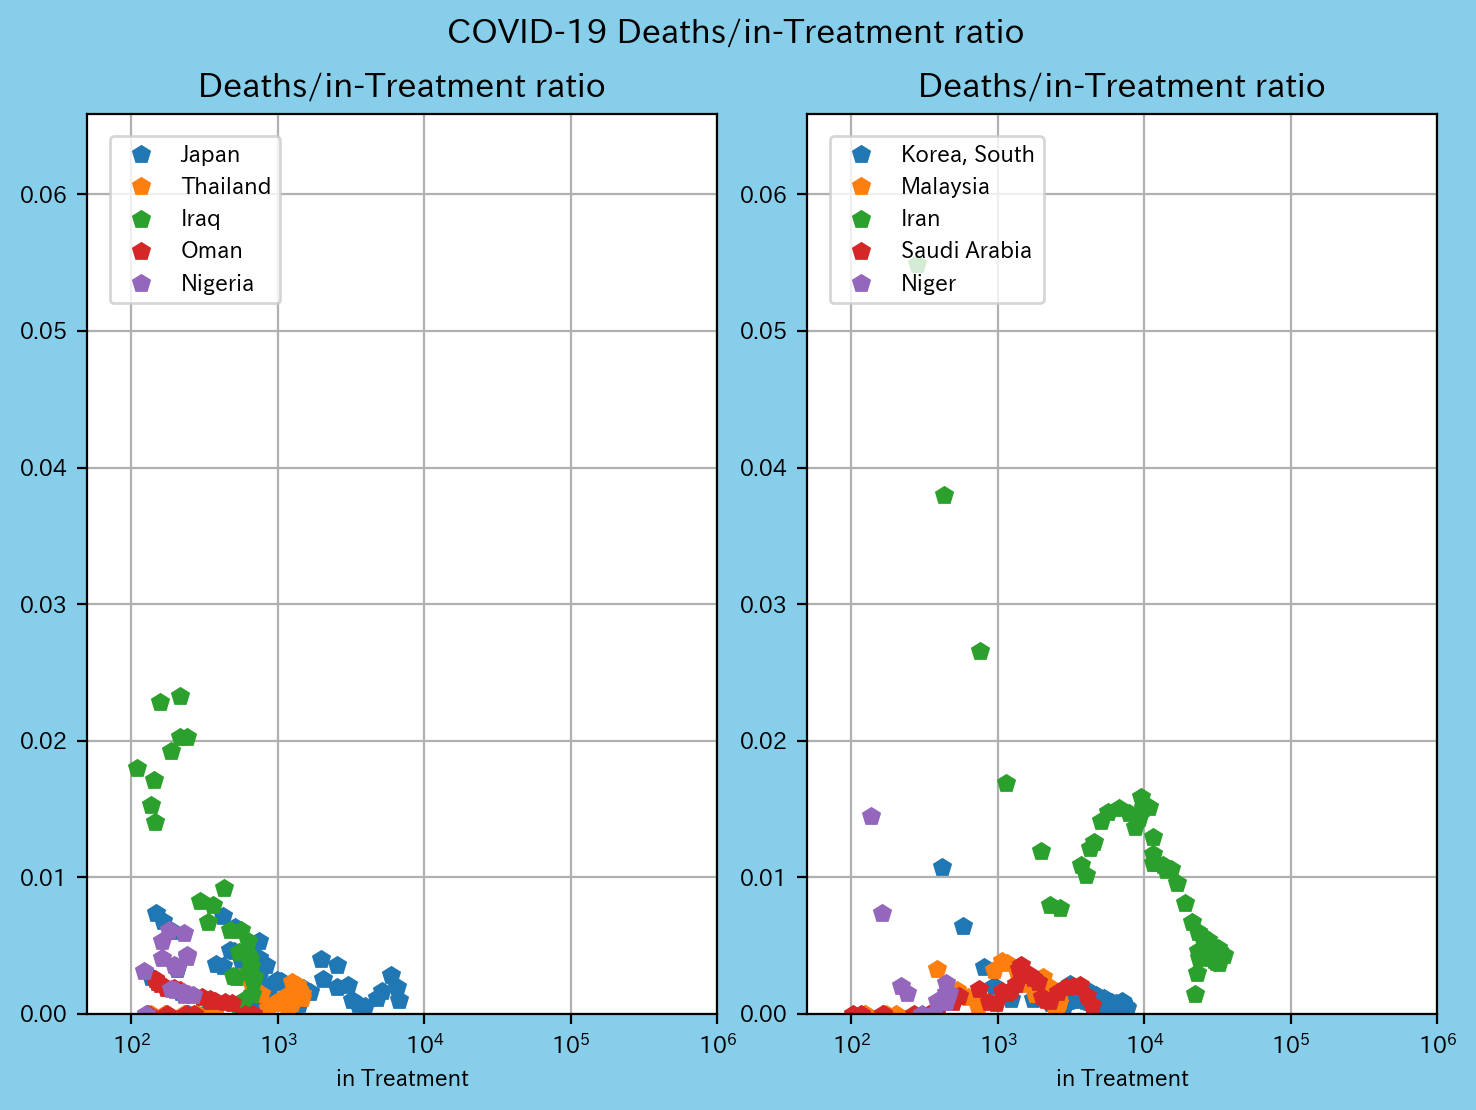

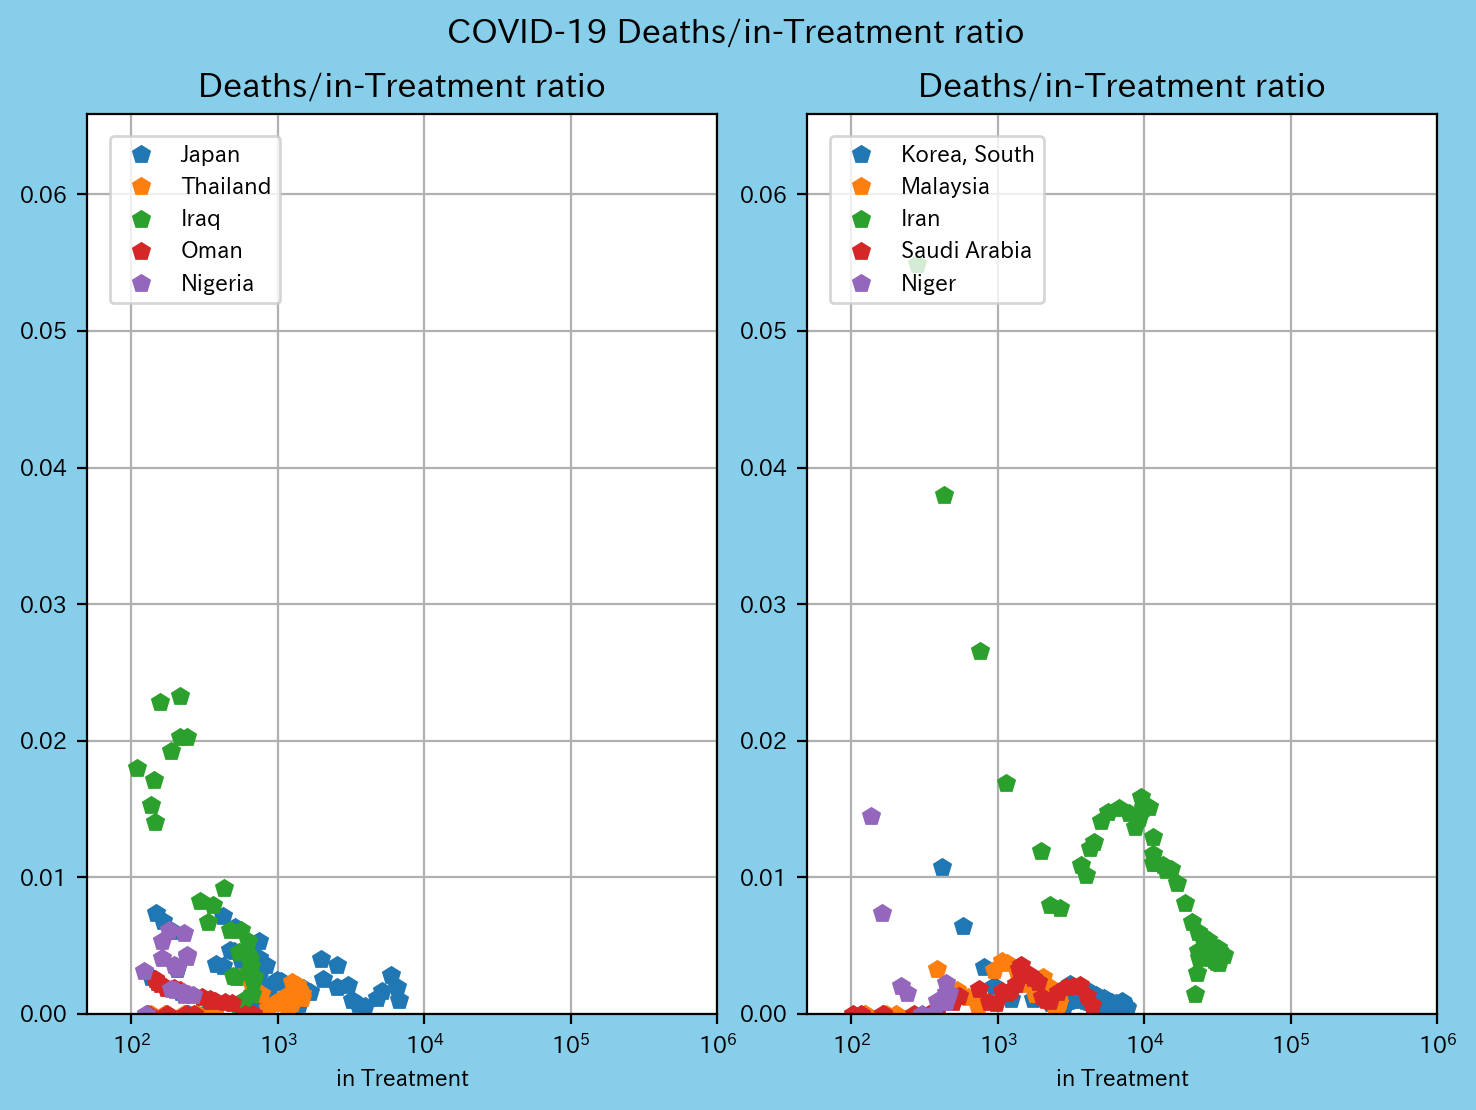

In [27]:
# BCG Japan/not
arealist_l = [ 'Japan', 'Thailand', 'Iraq', 'Oman', 'Nigeria'   ]
arealist_r = [ 'Korea, South', 'Malaysia', 'Iran', 'Saudi Arabia', 'Niger'  ]

title = 'Deaths/in-Treatment ratio'
ylabel = 'rD'
showCRDforAreaList_02(title, ylabel, arealist_l, arealist_r)

C:\Users\rse52\Anaconda3\lib\site-packages\matplotlib\axes\_base.py:2917: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  'left=%s, right=%s') % (left, right))


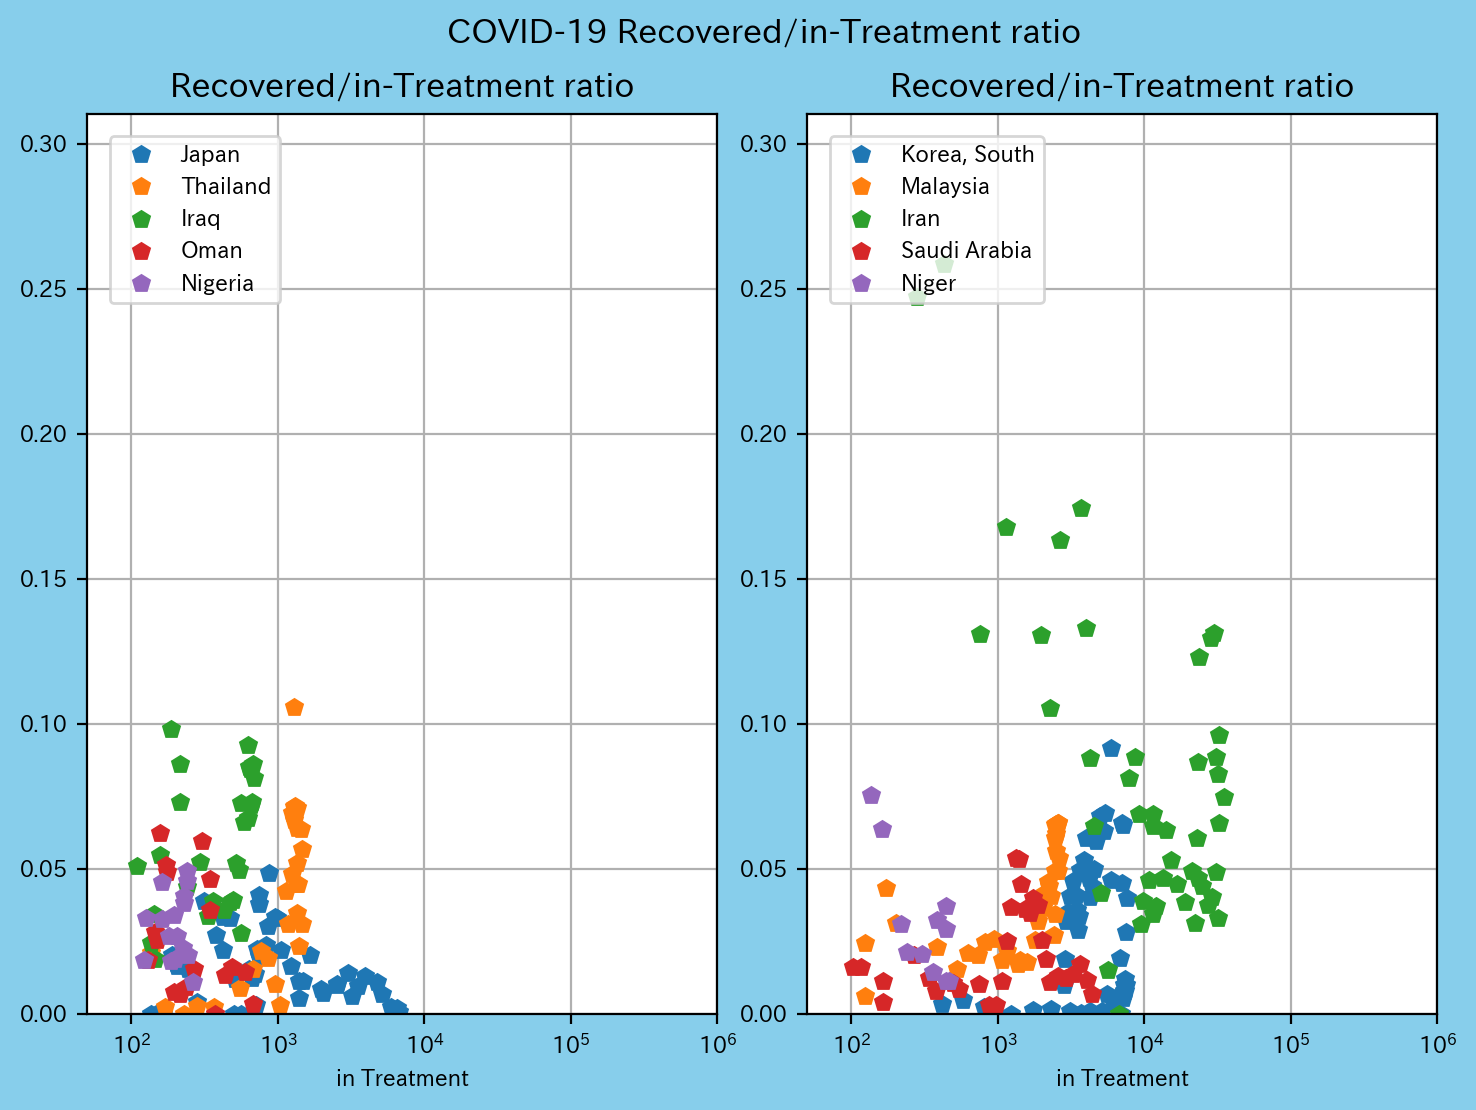

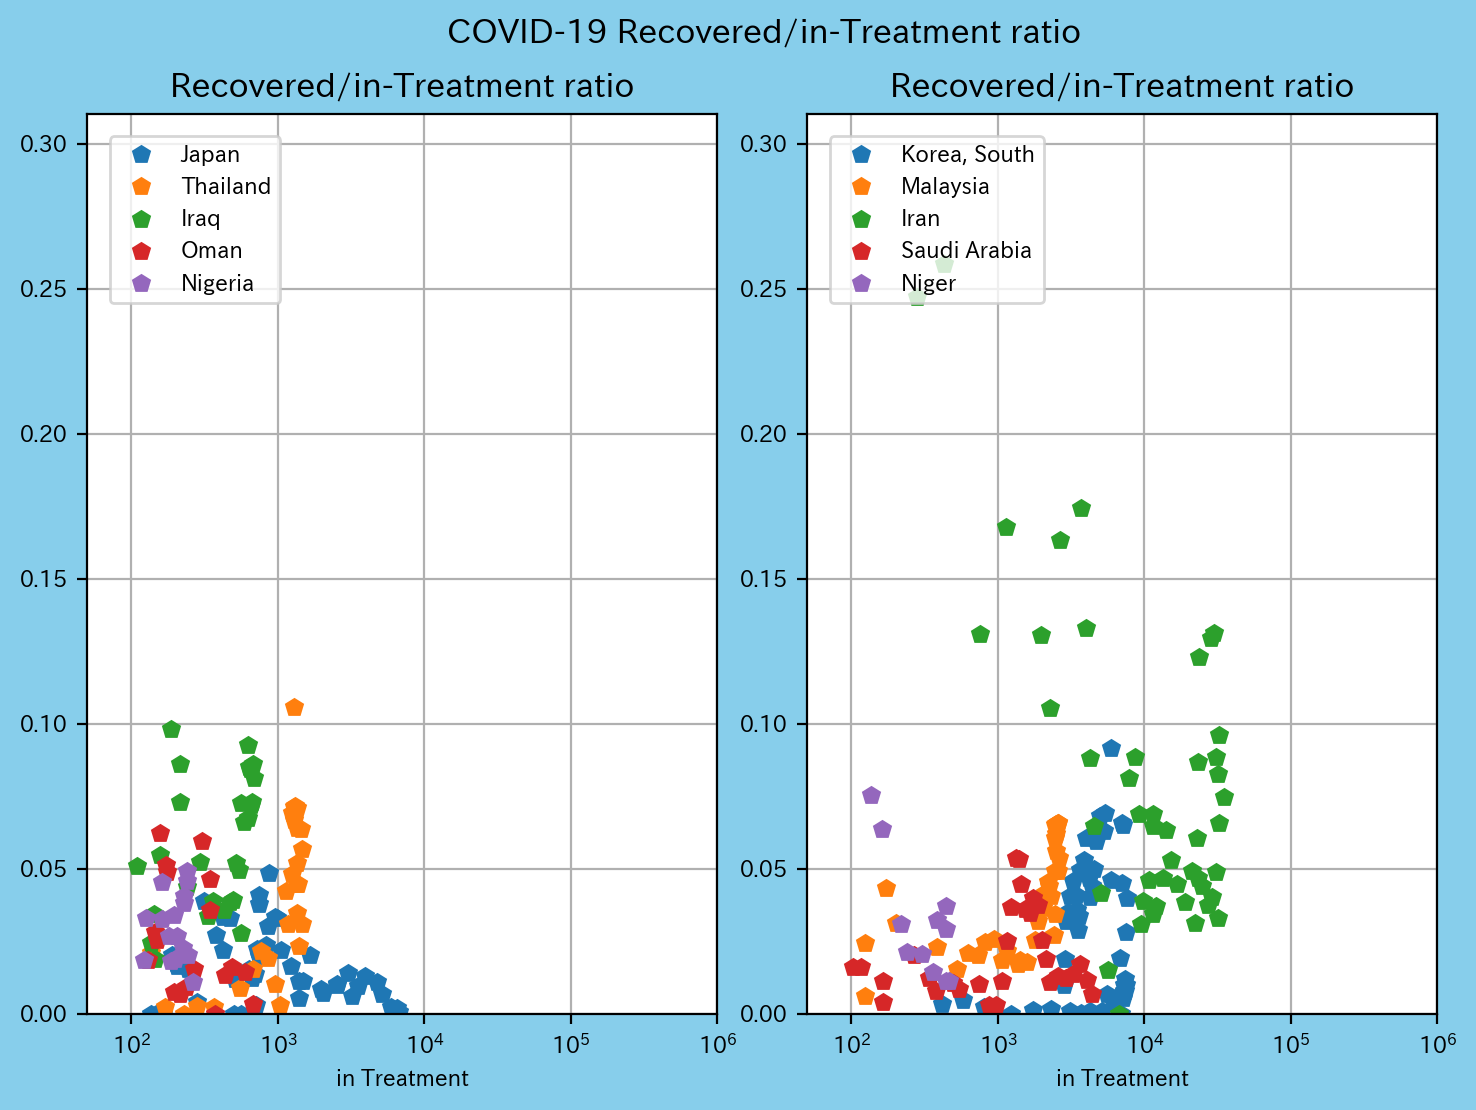

In [28]:
title = 'Recovered/in-Treatment ratio'
ylabel = 'rR'
showCRDforAreaList_02(title, ylabel, arealist_l, arealist_r)

In [29]:
##########################################################################################

In [30]:
##########################################################################################

In [31]:
##########################################################################################